In [1]:
import torch
import os
import pickle
import yaml
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from PIL import Image, ImageFilter
import warnings
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from utils.ImageSet import ImageSet
from utils.utils_tumor import (
    gen_image_from_coords,
    get_RdYlGr_masks,
    get_largest_connected_area,
    pej_color,
    non_pej_color,
    healthy_color,
)

warnings.filterwarnings("ignore")

In [2]:
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

batch_size = config["model"]["batch_size"]
patch_size = config["patching"]["patch_size"]
colors = {
    0: config["visualization"]["colors"]["healthy"],
    1: config["visualization"]["colors"]["non_pej"],
    2: config["visualization"]["colors"]["pej"],
}
colors_TNT = {
    0: config["visualization"]["colors"]["healthy"],
    1: config["visualization"]["colors"]["pej"],
    2: config["visualization"]["colors"]["pej"],
}
classes = ["NT", "Non Pej", "Pej"]

vis_scale = config["patching"]["vis_scale"]
step = int(vis_scale * patch_size)

cmap = plt.get_cmap(config["visualization"]["color_map"])
normalizer = Normalize(0, 1)
im = cm.ScalarMappable(normalizer, cmap)

In [3]:
tumor_checkpoints = "../" + config["paths"]["pth_to_tumor_ckpts"]
patches_dir = "../" + config["paths"]["pth_to_patches"]
coords_checkpoints = "../" + config["paths"]["pth_to_coords"]
preds_wsis_results = "../" + config["paths"]["pth_to_preds_wsis"]

In [4]:
slide_name = "222C"
chkpt_coords = torch.load(f"{coords_checkpoints}/{slide_name}_coords_checkpoint.pt")
chkpt_tumor = torch.load(f"{tumor_checkpoints}/{slide_name}_preds_probas_checkpoint.pt")

In [5]:
chkpt_tumor.keys()

dict_keys(['scaled_slide', 'coords_x', 'coords_y', 'har_mean_proba', 'har_mean_preds', 'geo_mean_proba', 'geo_mean_preds', 'arith_mean_proba', 'arith_mean_preds'])

In [6]:
coords_x = chkpt_tumor["coords_x"]
coords_y = chkpt_tumor["coords_y"]

[x_start, y_start, x_end, y_end] = chkpt_coords["xy_start_end"]
[real_x, real_y, real_w, real_h] = chkpt_coords["xywh_real"]
width, height = int(real_w * vis_scale), int(real_h * vis_scale)
# coords_x = np.array(coords_x) * vis_scale - x_start
# coords_y = np.array(coords_y) * vis_scale - y_start
y_har = chkpt_tumor["har_mean_preds"]
y_NT_NP_P = [np.array(colors[p.item()]) / 255 for p in y_har]

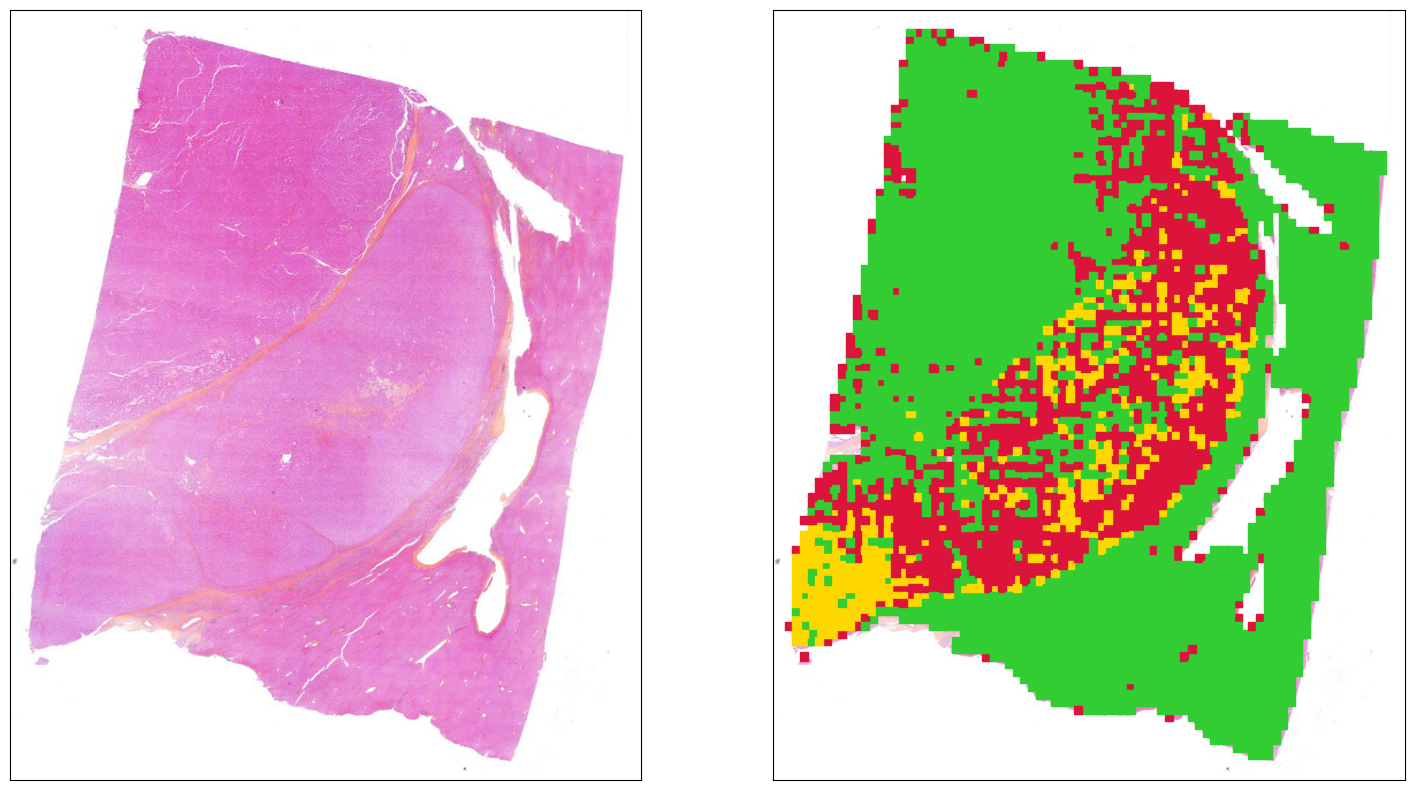

In [7]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(chkpt_tumor["scaled_slide"].astype(np.uint8))
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(chkpt_tumor["scaled_slide"].astype(np.uint8))
plt.scatter(coords_x, coords_y, c=y_NT_NP_P, marker="s")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

In [8]:
image = gen_image_from_coords(coords_x, coords_y, y_har, step, colors)
median_filtered = Image.fromarray(image).filter(
    ImageFilter.MedianFilter(size=2 * step + 1)
)
mode_filtered = np.array(
    Image.fromarray(image).filter(ImageFilter.ModeFilter(size=2 * step + 1))
)

masked_image_rd, masked_image_yl, masked_image_gr = get_RdYlGr_masks(mode_filtered)

(largest_zone_yl, num_px_yl) = get_largest_connected_area(
    masked_image_yl, non_pej_color
)
(largest_zone_rd, num_px_rd) = get_largest_connected_area(masked_image_rd, pej_color)
(largest_zone_gr, num_px_gr) = get_largest_connected_area(
    masked_image_gr, healthy_color
)

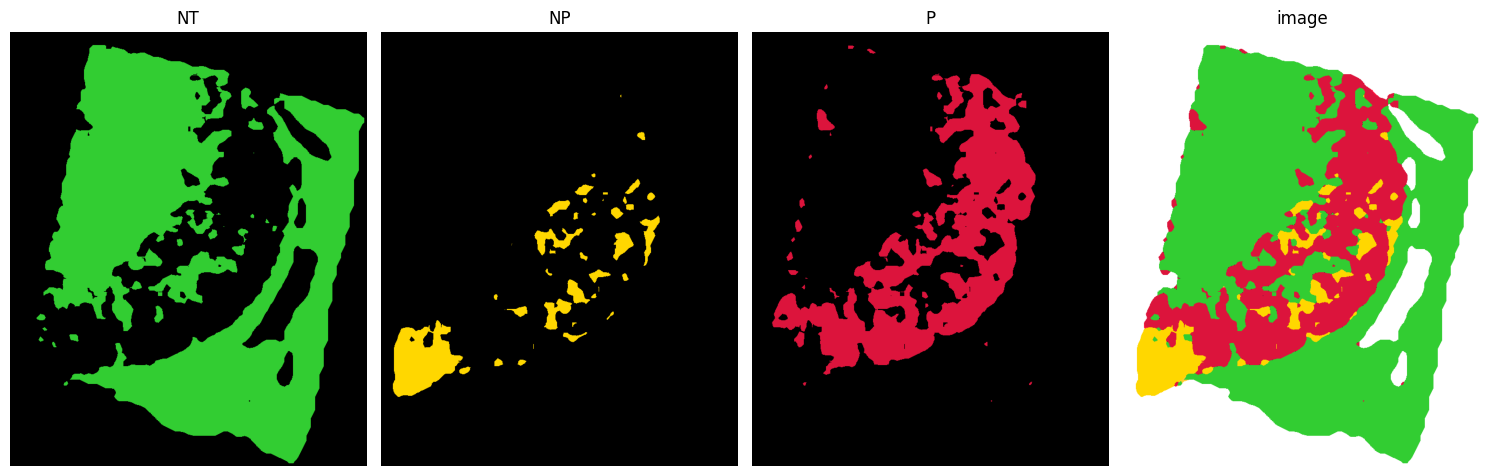

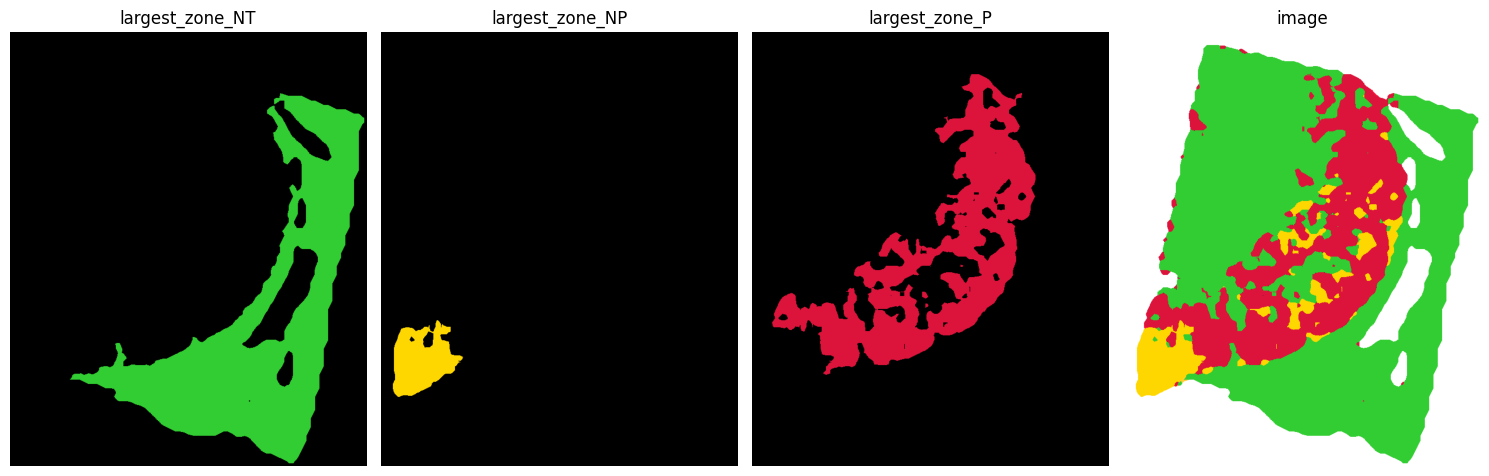

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(masked_image_gr)
axes[0].set_title("NT")
axes[0].axis("off")
axes[1].imshow(masked_image_yl)
axes[1].set_title("NP")
axes[1].axis("off")
axes[2].imshow(masked_image_rd)
axes[2].set_title("P")
axes[2].axis("off")
axes[3].imshow(mode_filtered)
axes[3].set_title("image")
axes[3].axis("off")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(largest_zone_gr)
axes[0].set_title("largest_zone_NT")
axes[0].axis("off")
axes[1].imshow(largest_zone_yl)
axes[1].set_title("largest_zone_NP")
axes[1].axis("off")
axes[2].imshow(largest_zone_rd)
axes[2].set_title("largest_zone_P")
axes[2].axis("off")
axes[3].imshow(mode_filtered)
axes[3].set_title("image")
axes[3].axis("off")
plt.tight_layout()
plt.show()